In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
os.chdir('..')

In [69]:
import pickle

from hydra import compose, initialize
from omegaconf import OmegaConf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

from tqdm.notebook import tqdm

from src.preprocessing.new_data_preprop import preprocessing
from src.datamodules.autoencoder import AEDataModule
from src.networks.lstm import LSTMAE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
BEST_MODEL_PATH = 'logs/lstm/checkpoints/lstm__embed_dim64_num_layers_1.ckpt'

In [5]:
with initialize(config_path='../config', version_base=None):
    cfg = compose(config_name='config')
cfg_preprop = cfg['dataset']
cfg_model = cfg['autoencoder']

In [6]:
seq_data = preprocessing(cfg_preprop)

In [7]:
datamodule = AEDataModule(
        None,
        seq_data,
        cfg_preprop['user_column'],
        cfg_preprop['mcc_column'],
        cfg_preprop['transaction_amt_column'],
        cfg_model['data_split']['val_size'],
        1,
        cfg_preprop['preproc']['len_max'],
        4,
        .5,
        False,
        binarize=False
    )

In [8]:
datamodule.setup('test')
dataloader = datamodule.test_dataloader()

In [9]:
best_model = LSTMAE.load_from_checkpoint(BEST_MODEL_PATH)

In [10]:
if not os.path.exists('data/new_data/results/'):
    os.mkdir('data/new_data/results/')

if not os.path.exists(
    f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}.npy'
):
    results = np.zeros((len(dataloader), 5), dtype=np.float32)

    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            outputs = best_model.predict_step(batch, i)
            results[i, 0] = batch[-1].cpu().numpy()
            results[i, 1] = outputs[0].cpu().numpy()
            results[i, 2:] = np.array(outputs[1])
    np.save(
        f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}',
        results
    )
else:
    results = np.load(
        f'data/new_data/results/model_{BEST_MODEL_PATH.split("/")[-1].split(".")[0]}.npy'
    )


In [11]:
results

array([[0.0000000e+00, 5.8996287e-04, 7.3414310e-05, 1.9821542e-07,
        4.9672701e-04],
       [2.5641026e-02, 1.6412984e-03, 1.4189981e-04, 1.1966280e-06,
        1.3797358e-03],
       [0.0000000e+00, 5.4374192e-04, 6.6896609e-05, 4.9191601e-07,
        4.2765372e-04],
       ...,
       [0.0000000e+00, 2.7134517e-04, 2.2178154e-05, 4.8992728e-08,
        2.4426775e-04],
       [0.0000000e+00, 2.7532619e-04, 1.5309244e-05, 4.6279162e-08,
        2.5538902e-04],
       [0.0000000e+00, 6.9053221e-04, 2.2241935e-05, 1.2244726e-07,
        6.5604557e-04]], dtype=float32)

In [12]:
anomaly_fraq = np.unique(results[:, 0])

In [13]:
losses = []
for fraq in anomaly_fraq:
    losses.append(results[np.argwhere(results[:, 0] == fraq)][:, 0, :])

In [14]:
losses = np.concatenate(losses)
losses_df = pd.DataFrame(losses, columns=['anomaly_fraq', 'loss', 'mcc_loss', 'binary_loss', 'amt_loss'])

In [15]:
def make_groups(fraq):
    if fraq < .2:
        return 0
    elif .2 <= fraq < .5:
        return 1
    elif .5 <= fraq < .7:
        return 2
    else:
        return 3
    
losses_df['class'] = losses_df['anomaly_fraq'].apply(make_groups)

In [18]:
agg_df = pd.DataFrame(losses_df.groupby('anomaly_fraq').agg({
    'loss': ['mean', 'std'],
    'mcc_loss': ['mean', 'std'],
    'binary_loss': ['mean', 'std'],
    'amt_loss': ['mean', 'std']
}))

In [34]:
agg_df['loss']['mean'].iloc[:100]

anomaly_fraq
0.000000    0.001748
0.003817    0.036149
0.004854    0.030879
0.007353    0.018340
0.008475    0.003224
              ...   
0.027027    0.003713
0.027397    0.002469
0.027778    0.004909
0.028169    0.002297
0.028302    0.003160
Name: mean, Length: 100, dtype: float32

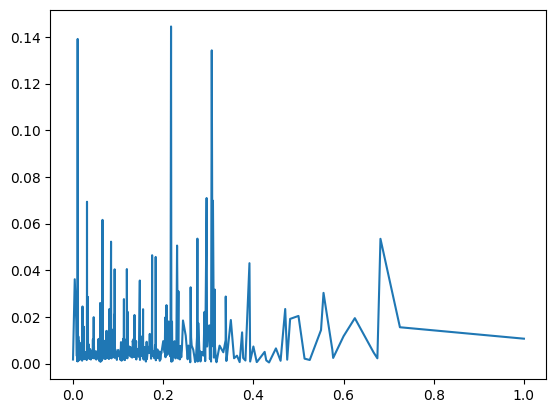

In [38]:
plt.plot(agg_df.index, agg_df['loss']['mean'])

<BarContainer object of 100 artists>

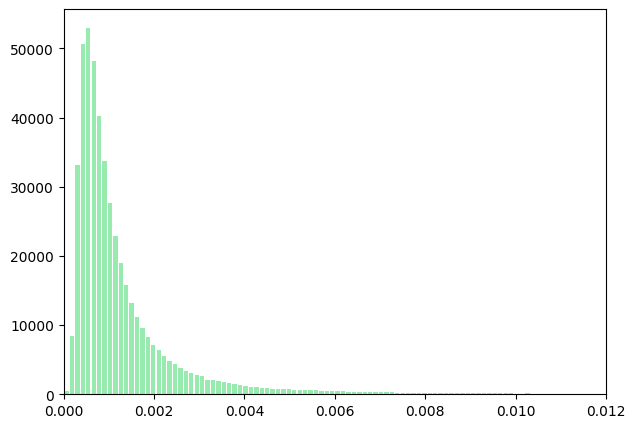

In [55]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = losses_df[losses_df['loss'] < .012]['loss']

# Get histogram
hist, bins = np.histogram(x, bins=100)
# hist = hist / np.sum(hist)

# Threshold frequency
freq = 0 #500

# Zero out low values
hist[np.where(hist <= freq)] = 0

# Plot
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([0, 0.012])
#plt.margins(0.05)
plt.bar(center, hist, align='center', width=width, color = '#33D860', label='normal', alpha=0.5)

<Axes: xlabel='loss'>

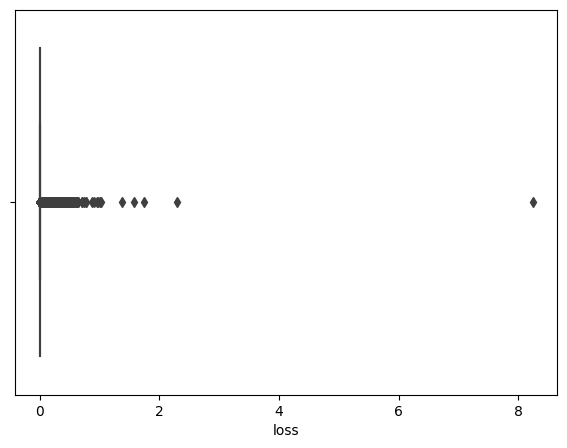

In [58]:
sns.boxplot(x=losses_df['loss'])

Важно! Модель посчитала аномалией набор транзакций с азартными играми (7995 - азартные игры/)

In [65]:
losses_df[losses_df['loss'] > 4]

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,class
228781,0.0,8.238477,0.000121,0.082316,0.006775,0


In [81]:
seq_data.iloc[228781][['mcc_code', 'user_id']]

mcc_code    [74, 74, 74, 74, 74, 20, 1, 74, 74, 74, 74, 74...
user_id                                                 10682
Name: 228782, dtype: object

In [91]:
np.exp(seq_data.iloc[228781]['transaction_amt'])

array([ 22.640741, 109.61357 , 104.53754 ,  46.06033 , 146.29277 ,
       906.0762  , 615.7704  ,  42.93056 ,  45.062397,  53.22185 ,
       106.4844  ,  49.638184,  41.42833 , 108.79991 ,  43.768253,
        91.294975,  26.3708  ,  46.409595,  74.03558 , 299.65143 ,
        52.786674,  55.04169 ,  47.810593,  42.436966,  92.17858 ,
        92.656   ,  90.42266 ,  45.48023 ,  54.039265,  55.719685,
       108.61172 , 108.3005  ,  52.05275 , 104.6088  , 165.3661  ,
        94.977066, 443.53137 ,  93.68741 ,  26.717432,  94.710556])

In [83]:
with open('data/new_data/preprocessed/mcc2id.dict', 'rb') as f:
    with open('data/new_data/preprocessed/user2id.dict', 'rb') as f_1:
        mcc2id = dict(pickle.loads(f.read()))
        user2id = dict(pickle.loads(f_1.read()))

In [84]:
id2mcc = {}
id2user = {}
for k, v in mcc2id.items():
    id2mcc[v] = k
for k, v in user2id.items():
    id2user[v] = k

In [75]:
id2mcc[74]

7995

In [92]:
losses_df[losses_df['loss'] > 1]

,anomaly_fraq,loss,mcc_loss,binary_loss,amt_loss,class
27003,0.000,2.301008,1.652921,1.368638e-06,0.647950,0
152523,0.000,1.026022,1.024961,8.510493e-08,0.001053,0
190996,0.000,1.750069,0.000349,1.661448e-02,0.088273,0
228781,0.000,8.238477,0.000121,8.231580e-02,0.006775,0
336094,0.000,1.584863,1.581835,1.119445e-06,0.002917,0
463958,0.075,1.010901,0.997991,1.396667e-06,0.012770,0
472099,0.100,1.370712,1.360427,1.221470e-06,0.010163,0


In [105]:
seq_data.iloc[152523]['mcc_code']

array([ 4, 27,  4, 17, 11, 11,  1,  1,  1,  4,  4,  4, 29, 27, 10,  1,  4,
        3,  1, 27, 79,  4,  4, 45, 45,  1,  1, 83, 20, 10,  9,  9, 83,  4,
        4, 10,  4,  4,  1, 10])

In [106]:
np.exp(seq_data.iloc[152523]['transaction_amt'])

array([  105.706215,   453.6131  ,   637.0809  ,  2113.6567  ,
        3734.1477  ,  5319.124   ,   577.4285  ,   452.62314 ,
        1194.3778  ,    45.360874,   177.24718 ,    93.19953 ,
        2469.5986  ,   827.13464 ,   207.84126 ,   937.9837  ,
         106.322   , 14444.672   ,   669.1018  ,   465.40512 ,
         848.62244 ,    92.386734,   172.4608  ,    18.137623,
         397.60193 ,   514.62616 ,   627.13965 ,  2120.0928  ,
        1160.5157  ,   179.77898 ,   105.38092 ,   789.8764  ,
         741.5316  ,   512.9007  ,    89.932335,    74.01915 ,
         108.026276,   108.19927 ,   787.0158  ,   214.07022 ])

In [107]:
id2mcc[45]

4121

In [79]:
orig_df = pd.read_parquet('data/new_data/transactions.parquet')

In [88]:
orig_df[(orig_df['user_id'] == id2user[10682]) & (orig_df['mcc_code'] == 7995)]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
9427255,782283ce1b594f618f8424fe25500c85,7995,48,-40.205284,2020-07-31 06:38:43
9427258,782283ce1b594f618f8424fe25500c85,7995,48,-36.907352,2020-08-01 06:45:14
9427259,782283ce1b594f618f8424fe25500c85,7995,48,-47.200695,2020-08-01 06:53:42
9427260,782283ce1b594f618f8424fe25500c85,7995,48,-36.507774,2020-08-01 07:27:25
9427262,782283ce1b594f618f8424fe25500c85,7995,48,-37.392696,2020-08-01 09:21:51
...,...,...,...,...,...
9428296,782283ce1b594f618f8424fe25500c85,7995,48,-90.043236,2021-01-24 03:22:03
9428297,782283ce1b594f618f8424fe25500c85,7995,48,-211.213870,2021-01-24 04:40:14
9428303,782283ce1b594f618f8424fe25500c85,7995,48,-22.310303,2021-01-26 14:16:54
9428304,782283ce1b594f618f8424fe25500c85,7995,48,-107.449690,2021-01-26 15:33:23
